## Retai Clickstream Analysis and Prediction

In [ ]:
#Install Pyspark and circlify
!pip install pyspark
!pip install circlify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = "../input/2019-oct/2019-Oct.csv"
# !unzip "/content/drive/MyDrive/Awesom_Big_Data_Project/nk_data.zip"
!unzip "/content/drive/MyDrive/BigDataSet/archive.zip"

Archive:  /content/drive/MyDrive/BigDataSet/archive.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


In [ ]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import element_at, split, col
import pandas as pd
import os
import plotly.express as px

In [ ]:
conf = pyspark.SparkConf()
conf.set('spark.sql.repl.eagerEval.enabled', True)
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
#Creating a subset of
# def read_with_pandas(input_filepath):
#   raw_data = pd.read_csv(input_filepath, nrows = 500000)
#   output_filepath = "small_oct_2019.csv"
#   raw_data.to_csv(output_filepath)
#   return output_filepath

# input_filepath = "/content/2019-Oct.csv"
# input_filepath = read_with_pandas(input_filepath)

In [ ]:
# for v local machine
path_file_2019 = "/content/2019-Oct.csv"
output_show = True # it makes .show() on/off
small_data_testing = False # make it false when testing on whole dataset
if small_data_testing:
  raw_data = pd.read_csv(path_file_2019, nrows = 5000)
  raw_data.head(2)
  raw_data.to_csv("small_oct_2019.csv")
  path_file_2019 = "/content/drive/MyDrive/Awesom_Big_Data_Project/small_oct_2019.csv"

print("the file chosen is ", path_file_2019)
print("small data testing is ", small_data_testing)

the file chosen is  /content/2019-Oct.csv
small data testing is  False


In [ ]:
# For final we will take the full dataset
# path_file_2019 = "/content/drive/MyDrive/Awesom_Big_Data_Project/small_oct_2019.csv"
original_df = spark.read\
        .option("InferSchema","true")\
        .option("header","true")\
        .format("csv")\
        .load(path_file_2019)

In [ ]:
# Just keeping original_df in case we do some operation on df and loose track of original df
# add hyperloglog. Thats faster(Daniel)
# https://mungingdata.com/apache-spark/hyperloglog-count-distinct/
preprocessed_df = original_df

# **Dataset Overview**

In [ ]:
preprocessed_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



1) ***event_time*** : denotes the date and time of the user session.

2) ***event_type***: There are 3 events in this dataset (viewing, adding to cart, and purchase).

3) ***product_id***: indicates the specific product id.

4) ***category_id***: indicates the specific category id.

5) ***user_id***: pertains to the specific user.

6) ***user session***: a single user can have multiple sessions indicating various events like view, purchase, add to cart.

7) ***brand***: indicates the brand associated with the product and category.

8) ***cateogry***: indicates a nested string having a structure liek electronics.smartphone.andorid which helps us in specifying the range of purchased item.



# Data Summary and Pre-processing

In [ ]:
#Dropping NULL values in event_type is any
preprocessed_df = preprocessed_df.dropna(subset=["event_type"])

# Data Imputation

## Extracting Catgeory and Product

In [ ]:
# Imputing Category code and brand might have null values with the string "empty", instead of removing it.
preprocessed_df = preprocessed_df.na.fill(value = "empty", subset = ["category_code","brand"])

In [ ]:
if output_show:
  preprocessed_df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|               empty|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|   empty|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:04|      view|   1004237|2053013555631882655|electr

In [ ]:
#Deriving category and product names from the category_code column using UDF.
@udf
def extract_category(category, brand):
    newlist = str(category).split('.')
    if newlist[0]=="empty":
      if brand == "empty":
        return "unknown"
      return brand
    return newlist[0]

@udf
def extract_product(category, brand):
    newlist = str(category).split('.')
    if newlist[-1] == "empty":
      if brand == "empty":
        return "unknown"
      return brand
    return newlist[-1]

In [ ]:
df_category_product_extracted = preprocessed_df.select("*", extract_category("category_code", "brand"),  extract_product("category_code", "brand"))
df_category_product_extracted = df_category_product_extracted.withColumnRenamed("extract_category(category_code, brand)","category").withColumnRenamed("extract_product(category_code, brand)", "product")
df_category_product_extracted = df_category_product_extracted.drop("category_code")
if output_show:
  df_category_product_extracted.show(5)

+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+
|         event_time|event_type|product_id|        category_id|   brand|  price|  user_id|        user_session|   category|     product|
+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   shiseido|    shiseido|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|    aqua|   33.2|554748717|9333dfbd-b87a-470...| appliances|water_heater|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|   empty|  543.1|519107250|566511c2-e2e3-422...|  furniture|        sofa|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|  computers|    notebook|
|2019-10-01 00:00:04|      view|   100423

## Extracting Time features like Day, Time, Hour from Timestamp

In [ ]:
df_time = df_category_product_extracted.withColumn('Date', split(preprocessed_df['event_time'], ' ').getItem(0)).withColumn('Time', split(preprocessed_df['event_time'], ' ').getItem(1))
df_time = df_time.withColumn('Day', split(df_time['Date'], '-').getItem(2)).withColumn('Hour', split(df_time['Time'], ':').getItem(0))
df_time = df_time.drop("Date")
if output_show:
  df_time.show(5)

+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+--------+---+----+
|         event_time|event_type|product_id|        category_id|   brand|  price|  user_id|        user_session|   category|     product|    Time|Day|Hour|
+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+--------+---+----+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   shiseido|    shiseido|00:00:00| 01|  00|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|    aqua|   33.2|554748717|9333dfbd-b87a-470...| appliances|water_heater|00:00:00| 01|  00|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|   empty|  543.1|519107250|566511c2-e2e3-422...|  furniture|        sofa|00:00:01| 01|  00|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  lenov

In [ ]:
df = df_time

# Unique visitors in October

In [ ]:
unique_visitors = df.select(countDistinct("user_id"))
unique_visitors

count(DISTINCT user_id)
3022290


Analysis: The e-commerce site has a footfall of X unique visitors in the month of October

Future scope: If latitude/longitude is captured, we can also obtain demographic insights about potential customers.


# Journey of a user in one session


In [ ]:
df.filter(df.user_session=='b37abd25-7672-4dd7-a098-40e50e314388').orderBy("event_time").toPandas()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,category,product,Time,Day,Hour
0,2019-10-01 05:08:10,view,1005115,2053013555631882655,apple,975.57,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:08:10,01,05
1,2019-10-01 05:08:24,view,1005115,2053013555631882655,apple,975.57,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:08:24,01,05
2,2019-10-01 05:08:44,view,1005115,2053013555631882655,apple,975.57,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:08:44,01,05
3,2019-10-01 05:13:03,view,1005115,2053013555631882655,apple,975.57,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:13:03,01,05
4,2019-10-01 05:17:22,view,1003317,2053013555631882655,apple,957.53,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:17:22,01,05
5,2019-10-01 05:18:23,view,1002524,2053013555631882655,apple,514.76,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:18:23,01,05
6,2019-10-01 05:19:50,view,1005104,2053013555631882655,apple,975.57,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:19:50,01,05
7,2019-10-01 05:20:05,view,1002629,2053013555631882655,apple,377.14,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:20:05,01,05
8,2019-10-01 05:20:31,view,1003310,2053013555631882655,apple,746.29,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:20:31,01,05
9,2019-10-01 05:21:10,view,1005121,2053013555631882655,apple,949.83,526823608,b37abd25-7672-4dd7-a098-40e50e314388,electronics,smartphone,05:21:10,01,05


# Analysis of User Behaviour on the e-commerce site

In [ ]:
df_view = df[df['event_type'] == "view"]
df_cart = df[df['event_type'] == "cart"]
df_purchase = df[df['event_type'] == "purchase"]

In [ ]:
data = dict(
    count=[df_view.count(), df_cart.count(), df_purchase.count()],
    event_type=["View", "Cart", "Purchase"])
fig = px.funnel(data, x='event_type', y='count')
fig.show()

# Part 1: Determine best performing categories based on purchases



## Top 10 Categories Browsed and Purchased

### Top 10 Categories browsed

In [ ]:
df_cat_browsed = df.select("*").filter("event_type == 'view' OR event_type == 'cart'")
df_cat_purchased = df.select("*").filter("event_type == 'purchase'")

df_cat_browsed = df_cat_browsed.select("*").filter("category!='unknown'")
df_cat_browsed = df_cat_browsed.select("*").filter("product!='unknown'")

df_cat_purchased = df_cat_purchased.select("*").filter("category!='unknown'")
df_cat_purchased = df_cat_purchased.select("*").filter("product!='unknown'")

In [ ]:
df_cat_browsed_count = df_cat_browsed.groupBy("category").count().orderBy(desc("count")).limit(10)
df_cat_browsed_count = df_cat_browsed_count.withColumnRenamed("count", "category_browsed_count")


In [ ]:
if output_show:
  df_cat_browsed_count.show(5)

+-----------+----------------------+
|   category|category_browsed_count|
+-----------+----------------------+
|electronics|              15712595|
| appliances|               4892298|
|  computers|               2296362|
|    apparel|               1534922|
|  furniture|               1238859|
+-----------+----------------------+
only showing top 5 rows



In [ ]:
browsed_category = [val.category for val in df_cat_browsed_count.select('category').collect()]
browsed_count = [val.category_browsed_count for val in df_cat_browsed_count.select('category_browsed_count').collect()]
d = {'browsed_category': browsed_category, 'browsed_count': browsed_count}
fig = px.bar(d, x="browsed_category", y="browsed_count", title="Top 10 Categories Browsed", text_auto='.2s')
fig.show()

### Top 10 Categories Purchased

In [ ]:
df_cat_purchased_count = df_cat_purchased.groupBy("category").count().orderBy(desc("count")).limit(10)
df_cat_purchased_count = df_cat_purchased_count.withColumnRenamed("count", "category_purchase_count")

In [ ]:
if output_show:
  df_cat_purchased_count.show()

+------------+-----------------------+
|    category|category_purchase_count|
+------------+-----------------------+
| electronics|                 423028|
|  appliances|                  74996|
|   computers|                  27855|
|     lucente|                  11578|
|        auto|                  10620|
|    cordiant|                  10551|
|      xiaomi|                  10021|
|   furniture|                   8301|
|     apparel|                   8002|
|construction|                   7801|
+------------+-----------------------+



In [ ]:
purchase_category = [val.category for val in df_cat_purchased_count.select('category').collect()]
purchase_count = [val.category_purchase_count for val in df_cat_purchased_count.select('category_purchase_count').collect()]
d = {'purchase_category': purchase_category, 'purchase_count': purchase_count}
fig = px.bar(d, x="purchase_category", y="purchase_count", title="Top 10 Categories Purchased", text_auto='.2s')
fig.show()

Analysis: Top 10 for viewed and purchased differ

## Carted vs Purchased - Top Performing Products

In [ ]:
df_cat_carted = df.select("*").filter("event_type == 'cart'")
df_cp_cart_count = df_cat_carted.groupBy("category","product").count().orderBy(desc("count"))
df_cp_cart_count = df_cp_cart_count.withColumnRenamed("count", "cart_count")
if output_show:
  df_cp_cart_count.show(5)

+-----------+----------+----------+
|   category|   product|cart_count|
+-----------+----------+----------+
|electronics|smartphone|    549765|
|electronics| headphone|     51143|
|electronics|        tv|     36224|
|     xiaomi|    xiaomi|     22246|
| appliances|    washer|     21977|
+-----------+----------+----------+
only showing top 5 rows



In [ ]:
df_cp_purchase_count = df_cat_purchased.groupBy("category","product").count().orderBy(desc("count"))
df_cp_purchase_count = df_cp_purchase_count.withColumnRenamed("count", "purchase_count")
if output_show:
  df_cp_purchase_count.show()

+-----------+-------------+--------------+
|   category|      product|purchase_count|
+-----------+-------------+--------------+
|electronics|   smartphone|        338018|
|electronics|    headphone|         30503|
|electronics|           tv|         21565|
|electronics|       clocks|         17906|
| appliances|       washer|         16148|
|  computers|     notebook|         15590|
| appliances|       vacuum|         12378|
|    lucente|      lucente|         11578|
| appliances|refrigerators|         11218|
|   cordiant|     cordiant|         10551|
|     xiaomi|       xiaomi|         10021|
|   triangle|     triangle|          5835|
|electronics|       tablet|          5603|
|     nokian|       nokian|          4907|
|       auto|       player|          4647|
|       sony|         sony|          4496|
|    apparel|        shoes|          4255|
|electronics|    telephone|          3738|
| appliances|    microwave|          3709|
| appliances|         iron|          3653|
+----------

In [ ]:
df_product = df_cp_cart_count.join(df_cp_purchase_count, ["category", "product"], "left").orderBy(desc("purchase_count")).limit(20)
if output_show:
  df_product.show()

+-----------+-------------+----------+--------------+
|   category|      product|cart_count|purchase_count|
+-----------+-------------+----------+--------------+
|electronics|   smartphone|    549765|        338018|
|electronics|    headphone|     51143|         30503|
|electronics|           tv|     36224|         21565|
|electronics|       clocks|     20344|         17906|
| appliances|       washer|     21977|         16148|
|  computers|     notebook|     15627|         15590|
| appliances|       vacuum|     17263|         12378|
| appliances|refrigerators|     13126|         11218|
|   cordiant|     cordiant|      5730|         10551|
|     xiaomi|       xiaomi|     22246|         10021|
|   triangle|     triangle|       557|          5835|
|electronics|       tablet|      9140|          5603|
|     nokian|       nokian|      4906|          4907|
|       auto|       player|      1289|          4647|
|       sony|         sony|      6997|          4496|
|electronics|    telephone| 

In [ ]:
#Getting values for x-axis and y-axis
product = [val.product for val in df_product.select('product').collect()]
cart_count = [val.cart_count for val in df_product.select('cart_count').collect()]
purchase_count = [val.purchase_count for val in df_product.select('purchase_count').collect()]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Cart Count', x=product, y=cart_count),
    go.Bar(name='Purchase Count', x=product, y=purchase_count)
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Carted vs Purchase Count - Top Performing Products', xaxis_title = "Products", yaxis_title = 'Count')
fig.show()

### Top 5 Products Purchased in each Category

In [ ]:
from pyspark.sql.window import Window
window = Window.partitionBy(df_cp_purchase_count['category']).orderBy(df_cp_purchase_count['purchase_count'].desc())
ranked =  df_cp_purchase_count.select("*", rank().over(window).alias("rank")).filter(col('rank')<=5)
if output_show:
  ranked.orderBy(desc("count")).show(20)

+-----------+-------------+--------------+----+
|   category|      product|purchase_count|rank|
+-----------+-------------+--------------+----+
|electronics|   smartphone|        338018|   1|
|electronics|    headphone|         30503|   2|
|electronics|           tv|         21565|   3|
|electronics|       clocks|         17906|   4|
| appliances|       washer|         16148|   1|
|  computers|     notebook|         15590|   1|
| appliances|       vacuum|         12378|   2|
|    lucente|      lucente|         11578|   1|
| appliances|refrigerators|         11218|   3|
|   cordiant|     cordiant|         10551|   1|
|     xiaomi|       xiaomi|         10021|   1|
|   triangle|     triangle|          5835|   1|
|electronics|       tablet|          5603|   5|
|     nokian|       nokian|          4907|   1|
|       auto|       player|          4647|   1|
|       sony|         sony|          4496|   1|
|    apparel|        shoes|          4255|   1|
| appliances|    microwave|          370

Analysis: We can see that within electronics, smartphones are the most purchased products

### Top 5 Brands Browsed within each category

In [ ]:
df_cb_browsed_count = df_cat_browsed.groupBy("category","brand").count().orderBy(desc("count"))
if output_show:
  df_cb_browsed_count.show(5)

+-----------+-------+-------+
|   category|  brand|  count|
+-----------+-------+-------+
|electronics|samsung|4356048|
|electronics|  apple|3847629|
|electronics| xiaomi|2483135|
|electronics| huawei|1066546|
|  furniture|  empty| 703390|
+-----------+-------+-------+
only showing top 5 rows



In [ ]:
window = Window.partitionBy(df_cb_browsed_count['category']).orderBy(df_cb_browsed_count['count'].desc())
ranked =  df_cb_browsed_count.select("*", rank().over(window).alias("rank")).filter(col('rank')<=5)
if output_show:
  ranked.orderBy(desc("count")).show(5)

+-----------+-------+-------+----+
|   category|  brand|  count|rank|
+-----------+-------+-------+----+
|electronics|samsung|4356048|   1|
|electronics|  apple|3847629|   2|
|electronics| xiaomi|2483135|   3|
|electronics| huawei|1066546|   4|
|  furniture|  empty| 703390|   1|
+-----------+-------+-------+----+
only showing top 5 rows



Analysis: We can see that within electronics, samsung is most browsed brand

### Top 5 brands within each category Purchased

In [ ]:
df_cb_purchased_count = df_cat_purchased.groupBy("category","brand").count().orderBy(desc("count"))
if output_show:
  df_cb_purchased_count.show(5)

+-----------+-------+------+
|   category|  brand| count|
+-----------+-------+------+
|electronics|samsung|159621|
|electronics|  apple|141394|
|electronics| xiaomi| 44767|
|electronics| huawei| 23220|
|    lucente|lucente| 11578|
+-----------+-------+------+
only showing top 5 rows



In [ ]:
window = Window.partitionBy(df_cb_purchased_count['category']).orderBy(df_cb_purchased_count['count'].desc())
ranked =  df_cb_purchased_count.select("*", rank().over(window).alias("rank")).filter(col('rank')<=5)
if output_show:
  ranked.orderBy(desc("count")).show(5)

In [ ]:
import circlify
data = [{'id': 'World', 'datum': 6964195249, 'children' : [
              {'id' : "electronics", 'datum': 450448697,
                   'children' : [
                     {'id' : "samsung", 'datum' : 308865000},
                     {'id' : "apple", 'datum' : 107550697},
                     {'id' : "xiaomi", 'datum' : 34033000}
                   ]},
              {'id' : "appliances", 'datum' : 278095425,
                   'children' : [
                     {'id' : "samsung", 'datum' : 192612000},
                     {'id' : "elenberg", 'datum' : 45349000},
                     {'id' : "LG", 'datum' : 40134425}
                   ]},
              {'id' : "computers", 'datum' : 278095425,
              'children' : [
                {'id' : "acer", 'datum' : 192612000},
                {'id' : "lenovo", 'datum' : 45349000},
                {'id' : "Hp", 'datum' : 40134425}
              ]},
    ]}]

In [ ]:
# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    data,
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

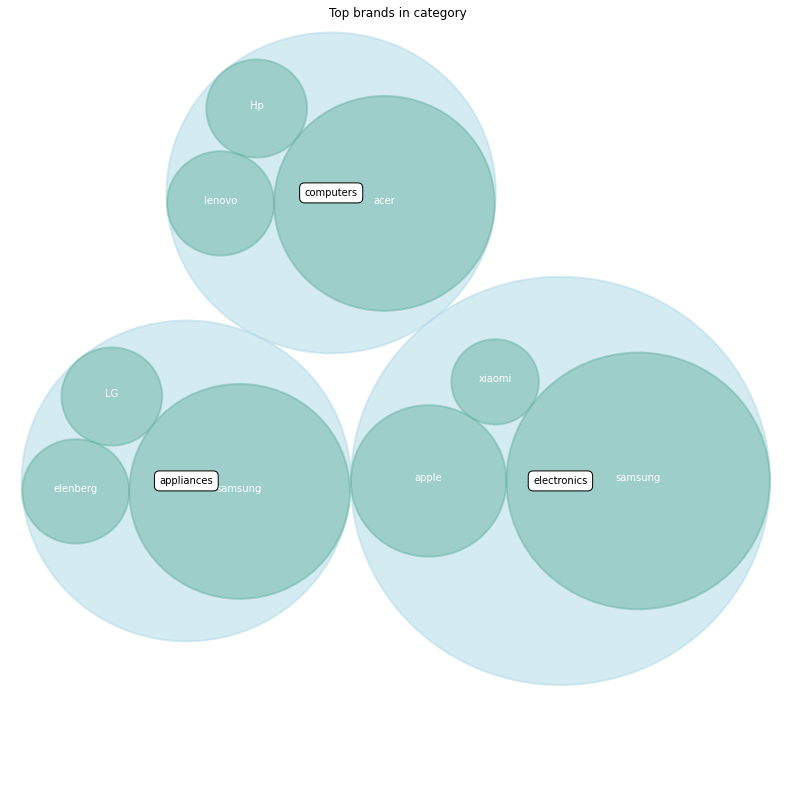

In [ ]:
# import libraries
import circlify
import matplotlib.pyplot as plt
import numpy as np
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(14,14))

# Title
ax.set_title('Top brands in category')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = -1
for circle in circles:
  k = np.max([np.abs(circle.x) + circle.r, np.abs(circle.y) + circle.r])
  lim = np.max([lim, k])

plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightblue"))

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2"))
    plt.annotate(label, (x,y ), ha='center', color="white")

# Print labels for the continents
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))


Analysis: TBD

# Part 2: Evaluate Add to Cart and Cart Abandonment Rate



## Cart Abandonment Rate

In [ ]:
df_only_cart = df.filter(df.event_type=="cart")
df_only_purchase = df.filter(df.event_type=="purchase")

### CAR by Category

In [ ]:
#Distinct category in cart
df_only_cart_cat_dis = df_only_cart.groupBy("category").count()
df_only_cart_cat_dis = df_only_cart_cat_dis.withColumnRenamed("count", "cart_count")

#Distinct category in purchase
df_only_purchase_cat_dis = df_only_purchase.groupBy("category").count()
df_only_purchase_cat_dis = df_only_purchase_cat_dis.withColumnRenamed("count", "purchase_count")

#Performing a left join
columns_ = df.columns
cart_purchase = df_only_cart_cat_dis.alias("cart_cat").join(df_only_purchase_cat_dis.alias("purchase_cat"),
                                                            df_only_cart_cat_dis["category"]==df_only_purchase_cat_dis["category"]).select("cart_cat.category", "cart_cat.cart_count", "purchase_cat.purchase_count")
if output_show:
  cart_purchase.show(5)

+---------+----------+--------------+
| category|cart_count|purchase_count|
+---------+----------+--------------+
| yokohama|      1758|          2735|
|  versace|       270|           465|
|  philips|      3337|          2417|
|energizer|         2|            14|
|microsoft|       298|           202|
+---------+----------+--------------+
only showing top 5 rows



In [ ]:
#Creating a UDF for calculating Cart Abandonment Rate
@udf(returnType=FloatType())
def cart_miss_rate_udf(cart_count, purchase_count):
  rate = (1 - purchase_count/cart_count)*100
  #rate_string = "{:.2f}".format(rate)
  return rate

In [ ]:
df_cart_miss_rate = cart_purchase.select("*", cart_miss_rate_udf("cart_count", "purchase_count"))
df_cart_miss_rate = df_cart_miss_rate.withColumnRenamed("cart_miss_rate_udf(cart_count, purchase_count)", "cart_miss_rate")
df_cart_miss_rate = df_cart_miss_rate.filter("cart_miss_rate>0")
df_cart_miss_rate = df_cart_miss_rate.filter("cart_count>5000")
df_cart_miss_rate = df_cart_miss_rate.orderBy(desc("cart_miss_rate")).limit(10)
if output_show:
  df_cart_miss_rate.show(5)

+------------+----------+--------------+--------------+
|    category|cart_count|purchase_count|cart_miss_rate|
+------------+----------+--------------+--------------+
|      xiaomi|     22246|         10021|       54.9537|
| electronics|    674205|        423028|     37.255287|
|        sony|      6997|          4496|      35.74389|
|construction|     10343|          7801|      24.57701|
|  appliances|     92362|         74996|     18.802105|
+------------+----------+--------------+--------------+



In [ ]:
category = [val.category for val in df_cart_miss_rate.select('category').collect()]
cart_miss_rate_list = [val.cart_miss_rate for val in df_cart_miss_rate.select('cart_miss_rate').collect()]

d = {'category':category, 'cart_miss_rate': cart_miss_rate_list}
fig = px.pie(d, values='cart_miss_rate', names='category', title="Cart Abandonment Rate for category")
fig.show()

Analysis: We can see that X category had the most cart abandonment rate with X%

### CAR by Brands

In [ ]:
# distinct brands in cart

df_only_cart_brand_dis = df_only_cart.filter("category=='electronics'").groupBy("brand").count()
df_only_cart_brand_dis = df_only_cart_brand_dis.withColumnRenamed("count", "cart_count")

# distinct brands in purchase
df_only_purchase_brand_dis = df_only_purchase.filter("category=='electronics'").groupBy("brand").count()
df_only_purchase_brand_dis = df_only_purchase_brand_dis.withColumnRenamed("count", "purchase_count")

#Performing a left join
cart_purchase_brand = df_only_cart_brand_dis.alias("cart_cat").join(df_only_purchase_brand_dis.alias("purchase_cat"),
                                                            df_only_cart_brand_dis["brand"]==df_only_purchase_brand_dis["brand"]).select("cart_cat.brand", "cart_cat.cart_count", "purchase_cat.purchase_count")
if output_show:
  cart_purchase_brand.show(5)


+--------+----------+--------------+
|   brand|cart_count|purchase_count|
+--------+----------+--------------+
| philips|       835|           426|
|takamine|         1|             6|
|   olmio|         4|           145|
|   epson|        89|            33|
|   texet|       592|           554|
+--------+----------+--------------+
only showing top 5 rows



In [ ]:
df_cart_miss_rate_brand = cart_purchase_brand.select("*", cart_miss_rate_udf("cart_count", "purchase_count"))
df_cart_miss_rate_brand = df_cart_miss_rate_brand.withColumnRenamed("cart_miss_rate_udf(cart_count, purchase_count)", "cart_miss_rate_brand")
df_cart_miss_rate_brand = df_cart_miss_rate_brand.filter("cart_miss_rate_brand>0")
df_cart_miss_rate_brand = df_cart_miss_rate_brand.filter("cart_count>5000")
df_cart_miss_rate_brand = df_cart_miss_rate_brand.orderBy(desc("cart_miss_rate_brand")).limit(10)
df_cart_miss_rate_brand.toPandas()

,brand,cart_count,purchase_count,cart_miss_rate_brand
0,oppo,20547,10891,46.994694
1,huawei,41683,23220,44.293839
2,xiaomi,79299,44767,43.546577
3,samsung,281410,159621,43.278133
4,apple,207504,141394,31.859627


In [ ]:
brand = [val.brand for val in df_cart_miss_rate_brand.select('brand').collect()]
cart_miss_rate_brand_list = [val.cart_miss_rate_brand for val in df_cart_miss_rate_brand.select('cart_miss_rate_brand').collect()]

d = {'brand':brand, 'cart_miss_rate': cart_miss_rate_brand_list}
fig = px.pie(d, values='cart_miss_rate', names='brand', title="Cart Abandonment Rate for brands")
#fig.update_traces(textinfo='value')
fig.show()

Analysis: Show brands with highest abandonment rate. Business users need to talk to brand people to work on their campaign.

# Part 3: Effect of day-time on purchase trends

## Purchase trends across the month

In [ ]:
df_view = df[df['event_type'] == "view"]
df_purchase = df[df['event_type'] == "purchase"]
df_cart = df[df['event_type'] == "cart"]

In [ ]:
df_purchase_date_count = df_purchase.groupby("Day").count()

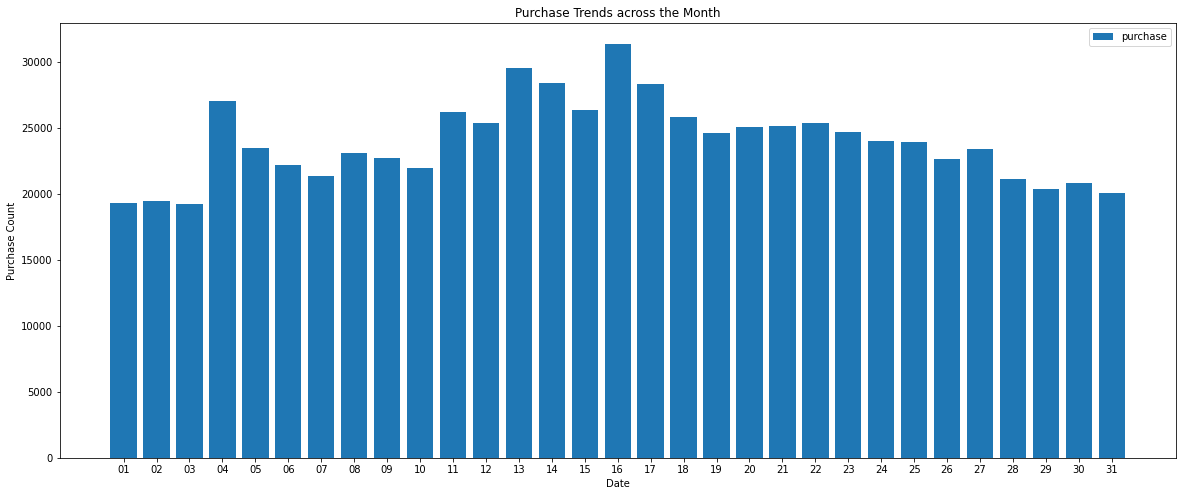

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

count = [val[0] for val in df_purchase_date_count.select('count').collect()]
date = [val.Day for val in df_purchase_date_count.select('Day').collect()]

plt.figure(figsize=(20, 8))
plt.bar(date, count)

plt.ylabel('Purchase Count')
plt.xlabel('Date')
plt.title('Purchase Trends across the Month')
plt.legend(['purchase'], loc='upper right')

plt.show()

Analysis: User's buying interest is gradually increasing in the middle of the month until day 16, therefore, to increase the sales we can offer mid-month sale/discount from day 11 until 16

## E-Commerce Prime Time

In [ ]:
df_view_hour_count = df_view.groupby("Hour").count().withColumnRenamed("count","view_count")
df_cart_hour_count = df_cart.groupby("Hour").count().withColumnRenamed("count","cart_count")
df_purchase_hour_count = df_purchase.groupby("Hour").count().withColumnRenamed("count","purchase_count")

In [ ]:
df_combined_type_hour = df_view_hour_count.join(df_cart_hour_count, ["Hour"],"left")
df_combined_type_hour = df_combined_type_hour.join(df_purchase_hour_count, ["Hour"], "left")
df_combined_type_hour = df_combined_type_hour.na.fill(value=0).orderBy('Hour')

In [ ]:
#purchase_count
hour = [val.Hour for val in df_combined_type_hour.select('Hour').collect()]
view_count = [val.view_count for val in df_combined_type_hour.select('view_count').collect()]
cart_count = [val.cart_count for val in df_combined_type_hour.select('cart_count').collect()]
purchase_count = [val.purchase_count for val in df_combined_type_hour.select('purchase_count').collect()]

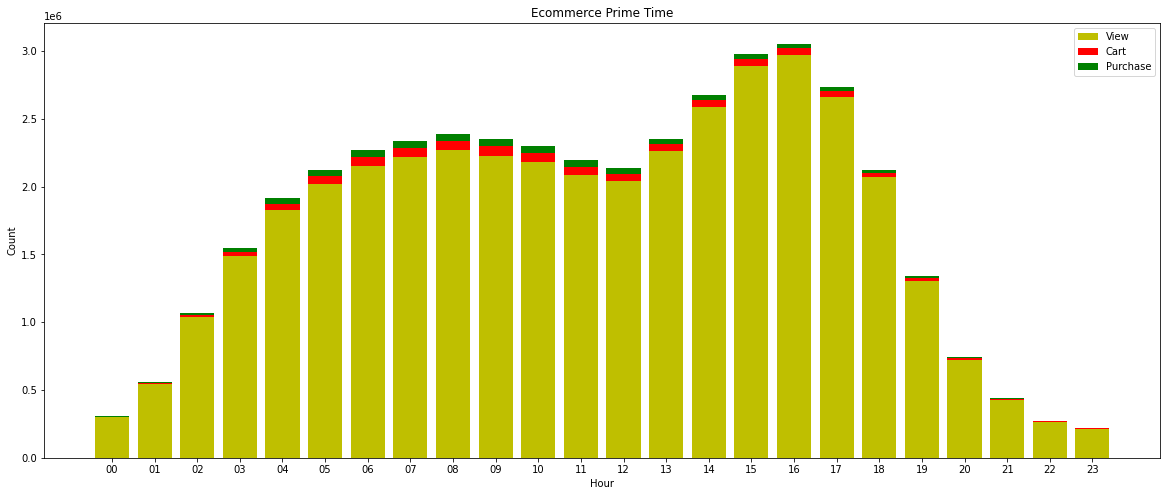

In [ ]:
#Data visualization of Ecommerce Prime Time
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.bar(hour, view_count, color='y')
plt.bar(hour, cart_count, bottom=view_count, color='r')
plt.bar(hour, purchase_count, bottom=[view + cart for view, cart in zip(view_count, cart_count)], color='g')
plt.xlabel("Hour")
plt.ylabel("Count")
plt.legend(["View", "Cart", "Purchase"])
plt.title("Ecommerce Prime Time")
plt.show()

Analysis: We can see from the graph that X number of users have already accessed our Ecommerce at 3:00 In the morning, it is increasing significantly in the afternoon and reached peak time at 16:00. Hence, a flash sale from 13:00 until 16:00 will help in increasing the impulsivity of the user for buying items

#Part 4: Predict whether the product added to cart is actually purchased?



## Data Processing

In [ ]:
df.groupBy("event_type").count()

event_type,count
purchase,742849
view,40779399
cart,926516


In [ ]:
#Unique number of people who have added products to the cart or purchase
cart_purchase_users = df.filter("event_type == 'cart' OR event_type == 'purchase' ")
distinct_cart_purchase = cart_purchase_users.drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
distinct_cart_purchase.groupby("event_type").count()

event_type,count
purchase,690618
cart,628955


In [ ]:
#All user activity for adding product to cart or purchased
columns_ = df.columns
cart_purchase_users_all_activity = df.alias("d").join(cart_purchase_users.alias("c"), df["user_id"]==cart_purchase_users["user_id"]).select("d.user_id", "d.event_time", "d.event_type", "d.product_id", "d.category_id", "d.brand", "d.price", "d.user_session", "d.category", "d.product")
cart_purchase_users_all_activity.groupBy("event_type").count()

event_type,count
purchase,10733318
view,100913032
cart,12799325


## High Value Customers

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session']).count()
if output_show:
  activity_in_session.show(5)

+--------------------+-----+
|        user_session|count|
+--------------------+-----+
|ec82d195-6607-47a...|    7|
|f6dd0b68-7280-495...|    4|
|62b9a2b1-c85b-441...|  100|
|bf56200c-93bc-4f0...|    8|
|6a996a01-2154-482...|    1|
+--------------------+-----+
only showing top 5 rows



## Label Encoding Target Variable

In [ ]:
@udf(returnType=IntegerType())
def is_purchased_label(purchase):
  if purchase == "purchase":
    return 1
  return 0

In [ ]:
df_targets = distinct_cart_purchase.select("*", is_purchased_label("event_type"))
df_targets = df_targets.withColumnRenamed("is_purchased_label(event_type)","is_purchased")

In [ ]:
df_targets = df_targets.join(activity_in_session, on="user_session",how="left")

In [ ]:
from datetime import datetime
@udf(returnType=IntegerType())
def week(s):
  return datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()

In [ ]:
df_targets_week = df_targets.select("*", week("event_time"))
df_targets_week = df_targets_week.withColumnRenamed("week(event_time)", "week")

In [ ]:
df_targets_week.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- product: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Hour: string (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- week: integer (nullable = true)



In [ ]:
df_targets_week = df_targets_week.dropDuplicates(["user_session"])

## Feature Selection

In [ ]:
features = df_targets_week.select("event_type", "brand", "price", "count","week","category", "product","is_purchased")
features.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- count: long (nullable = true)
 |-- week: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- product: string (nullable = true)
 |-- is_purchased: integer (nullable = true)



In [ ]:
features.count()

910797

## Prediction Model - SparkML

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

categotyIdxer = StringIndexer(inputCol='category',outputCol='category_idx')
event_typeIdxer = StringIndexer(inputCol='event_type',outputCol='event_type_idx')
brandIdxer = StringIndexer(inputCol='brand',outputCol='brand_idx')
productIdxer = StringIndexer(inputCol='product',outputCol='product_idx')
labelIndexer = StringIndexer(inputCol="is_purchased", outputCol="label")

one_hot_encoder_category = OneHotEncoder(inputCol="category_idx", outputCol="category_vec")
one_hot_encoder_product = OneHotEncoder(inputCol="product_idx", outputCol="product_vec")
one_hot_encoder_brand = OneHotEncoder(inputCol="brand_idx", outputCol="brand_vec")
one_hot_encoder_event_type = OneHotEncoder(inputCol="event_type_idx", outputCol="event_type_vec")

stages_indexer = [categotyIdxer,
          event_typeIdxer,
          brandIdxer,
          productIdxer,
          labelIndexer]
stages_one_hot = [
          one_hot_encoder_category,
          one_hot_encoder_event_type,
          one_hot_encoder_brand,
          one_hot_encoder_product]


assembler_cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in stages_one_hot], outputCol="features_cat")
num_cols = ["count", "week", "price"]
assemblerNum = VectorAssembler(inputCols = num_cols, outputCol = "features_num")
final_assembler = VectorAssembler(inputCols = ["features_cat", "features_num"], outputCol = "features")
pipeline = Pipeline(stages = stages_indexer + stages_one_hot + [assembler_cat] + [assemblerNum]+ [final_assembler])

In [ ]:
features = features.na.drop()
df_transformed = pipeline.fit(features).transform(features)
if output_show:
  df_transformed.show(2)

+----------+-------+------+-----+----+-----------+----------+------------+------------+--------------+---------+-----------+-----+----------------+--------------+----------------+----------------+--------------------+-----------------+--------------------+
|event_type|  brand| price|count|week|   category|   product|is_purchased|category_idx|event_type_idx|brand_idx|product_idx|label|    category_vec|event_type_vec|       brand_vec|     product_vec|        features_cat|     features_num|            features|
+----------+-------+------+-----+----+-----------+----------+------------+------------+--------------+---------+-----------+-----+----------------+--------------+----------------+----------------+--------------------+-----------------+--------------------+
|      cart|samsung| 171.9|  165|   4|electronics|smartphone|           0|         0.0|           0.0|      0.0|        0.0|  0.0|(1334,[0],[1.0])| (1,[0],[1.0])|(1971,[0],[1.0])|(1439,[0],[1.0])|(4745,[0,1334,133...|[165.0,4.0,1

In [ ]:
final_data = df_transformed.select("features", "label")
final_data = final_data.na.drop()
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
(trainingData, testData) = final_data.randomSplit([0.7, 0.3])

Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label',
                            featuresCol='features',
                            maxDepth=5)
model = rf.fit(trainingData)
rf_predictions = model.transform(testData)

Saving and loading model from file

In [ ]:
path_to_model = "/content/drive/MyDrive/Awesom_Big_Data_Project/bd_models/RF_model"
model.save(path_to_model)

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel
model_1 = RandomForestClassificationModel.load(path_to_model)
accuracy = rf_predictions.filter(rf_predictions.label == rf_predictions.prediction).count() / float(rf_predictions.count())
print("Accuracy : ",accuracy)


Accuracy :  0.7842197931186267
